# Introduction

This notebook will go through the basic steps of preparing the input and calculating non-local quantities.

# Input

The first step will be the preparation of input data. For this tutorial we assume, that you have been provided with a file containing the DMFT output data. 

We will convert this file to an input file for the `LadderDGA.jl` code and generate a frequency mesh. 

## TRIQS Conversion

If you are starting out with DMFT data from TRIQS, the `triqs_conv.jl` script in the scripts subdirectory of the `LadderDGA.jl` code will responsible for the conversion. This script also utilizes the `SparseVertex` and `EquivalencyClassesConstructor.jl` packages. 

Most of the conversion scripts are built to be called from the command line with the input given as parameters.
In Julia call parameters are stored in the `ARGS` array. Thus, in order to emulate a call with parameters in jupyter notebooks, we will modify this array befor calls to scripts.

We start by adding the path to a triqs output file and a directory for the script output (`@__DIR__` points to the directory the current script runs in) to the `ARGS` array and executing the `triqs_conv.jl` script for this input.
The input file is NOT provided with this example!

If you want to know more about a function, you can type `? function_name` in any cell to view the docstring.

In [ ]:
path_to_input = "/home/julian/Hamburg/ladderDGA_triqs/ladderDGA/U2_n1_b12.h5"
path_to_output = @__DIR__
empty!(ARGS)
push!(ARGS,path_to_input)
push!(ARGS,path_to_output)
include("../scripts/triqs_conv.jl")

## Config File
You will find two new files in the `path_to_output` directory. Before we can start the calculation we need to specify a configuration file which will point `LadderDGA.jl` to these files and provide all necessary parameters.

You will find an example configuration named `config.toml` in the root directory of `LadderDGA.jl`.
`U`, `mu`, `beta`, `nden` and `kGrid` should be set according to your DMFT calculation. The syntax for the `kGrid` parameter is as follows: The grid is given as a string starting with the grid name (see also `Dispersions.jl` for more information), followed by additional parameters, separated by `-`. Currently `2Dsc` and `3Dsc` are available with a single parameter for the hopping to neighbouring sites. Examples are `"2Dsc-0.25"` or `"3Dsc-0.408248"`

Remember to set the `inputDir` and `freqFile` variables to the previously generated files.

# Running the code

The `LadderDGA.jl` code consists of a collection of functions but no linear program flow. This means one has to define a script which defines the actual program flow.
Some examples can be found in the root directory of the project. Here we will go through a typical program flow, also giving us the opportunity to plot quantities at differnts steps of the calculation.
First, point the `cfg_file` variable to your edited configuration file.
We then also tell Julia to use `Plots` and `LadderDGA`.

In [1]:
cfg_file = "../config.toml"

using Plots
using LadderDGA

┌ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b]
└ @ Base loading.jl:1317


The next step will read the config and input files and set up all variables for you.
The `kGrids` and `qGrids` (reduced k grid) arrays contain k grids of the sizes specified in the `Nk` array in your `config.toml`. 
This can be handy for finite size scaling, but for now we will stick with simple calculations and only use a single k grid size.
Finally we will also need to read in the DMFT quantities. `setup_LDGA` will do just that.

Note: the full grids (here stored in the kGrids array) are deprecated. They will be removed from future versions, together with most debug variables (all variables in the return list of `readConfig` after `qGridLoc`).

In [2]:
mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
qG = qGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/lDGATools/LadderDGA.jl/src/IO.jl:7
┌ Warning: hardcoded 3D cP lattice with t = 0.4082
└ @ LadderDGA /home/julian/lDGATools/LadderDGA.jl/src/IO.jl:74
┌ Info: loading from 
│   env.inputVars = triqs_out.jld2
└ @ LadderDGA /home/julian/lDGATools/LadderDGA.jl/src/helpers.jl:74
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ LadderDGA /home/julian/lDGATools/LadderDGA.jl/src/helpers.jl:108
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local susceptibility of length 
│   sp: 43
│   ch: 43 
│   χLoc_sp = 0.2081, χLoc_ch = 0.1304
└ @ LadderDGA /home/julian/lDGATools/LadderDGA.jl/src/helpers.jl:149


We are now in the position to calculate the ladder DGA self energy. The first 5 lines compute all quantities on a lattice of size 1. The resulting self energy is used to cancel out discretization errors and finite size effects in the full self energy.

In [ ]:
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP)
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo, qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;


bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, qG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, qG, νGrid, sumHelper_f, -mP.U, mP, sP);

λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, qG, mP, sP)

Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, qG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)]


# Sum Extrapolations

┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:55
┌ Info: loading from 
│   env.inputVars = ED_out.jld2
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:81


8:34
SeriesAcceleration.Richardson(10:14, [100.04166666666667; -682.6666666666666; 1640.25; -1666.6666666666667; 610.0416666666666])


┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:110
┌ Info: Constructing fit kernels
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:131
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local susceptibility of length 
│   sp: 27
│   ch: 27 
│   χLoc_sp = 0.2836, χLoc_ch = 0.0207
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:157


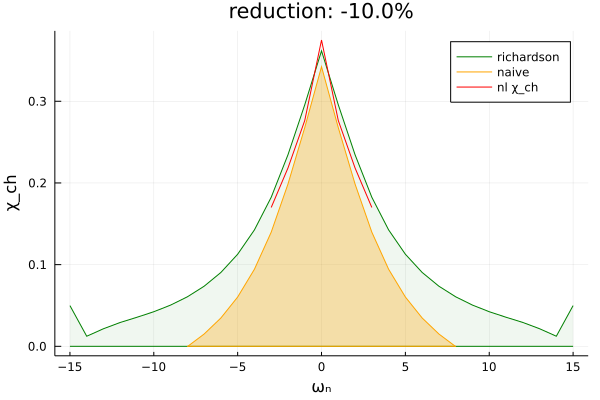

GKS: file open error (/home/julian/.julia/artifacts/1a66b11d6abb05af040a2154cbf84193d5d04f33/lib/../fonts/gksfont.dat)
open: No such file or directory
GKS: file open error (/home/julian/.julia/artifacts/1a66b11d6abb05af040a2154cbf84193d5d04f33/lib/../fonts/gksfont.dat)
open: No such file or directory


In [52]:
# naive:
mP, sP, env, kGrid, qGrid, νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc_pos, FUpDo, gImp = setup_LDGA(conf, false);
χchED_ω_naive = sum(impQ_ch.χ,dims=[2,3])[:,1,1]/(mP.β^2);
χspED_ω_naive = sum(impQ_sp.χ,dims=[2,3])[:,1,1]/(mP.β^2);
χch_ω = sum_q(nlQ_ch.χ, qGrid.multiplicity, dims=2)[:,1]
χsp_ω = sum_q(nlQ_sp.χ, qGrid.multiplicity, dims=2)[:,1]


reduction_prct = -0.1
χchED_ω_fit = [LadderDGA.sum_freq(impQ_ch.χ[i,:,:], [1,2], sumHelper_f, mP.β)[1,1] for i in 1:size(impQ_ch.χ,1)];
χspED_ω_fit = [LadderDGA.sum_freq(impQ_sp.χ[i,:,:], [1,2], sumHelper_f, mP.β)[1,1] for i in 1:size(impQ_sp.χ,1)];
usable_ch = LadderDGA.find_usable_interval(real(χchED_ω_fit), reduce_range_prct=reduction_prct)
usable_sp = LadderDGA.find_usable_interval(real(χspED_ω_fit), reduce_range_prct=reduction_prct)
usable_fit_DMFT = intersect(usable_ch, usable_sp)

usable_naive_ch = LadderDGA.find_usable_interval(real(χchED_ω_naive), reduce_range_prct=reduction_prct)
usable_naive_sp = LadderDGA.find_usable_interval(real(χspED_ω_naive), reduce_range_prct=reduction_prct)


plot(usable_ch .- sP.n_iω .- 1, real(χchED_ω_fit[usable_ch]), label="richardson", c=:green)
plot!(usable_ch .- sP.n_iω .- 1, repeat([0], length(usable_ch)), fillrange=real(χchED_ω_fit[usable_ch]), fillalpha=0.06, c=:green, label=nothing)

plot!(usable_naive_ch .- sP.n_iω .- 1, real(χchED_ω_naive[usable_naive_ch]), label="naive", xlabel="ωₙ", ylabel="χ_ch", c=:orange, title="reduction: $(reduction_prct*100)%")
plot!(usable_naive_ch .- sP.n_iω .- 1, repeat([0], length(usable_naive_ch)), fillrange=real(χchED_ω_naive[usable_naive_ch]), fillalpha=0.3, c=:orange, label=nothing)

plot!(nlQ_ch.usable_ω .- sP.n_iω .- 1, real(χch_ω[nlQ_ch.usable_ω]), label="nl χ_ch", c=:red)